## 程式主要功能 
* one shot analysis

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

import tkinter
from tkinter import*
# Create Tk root
root = Tk()
# Hide the main window
root.withdraw()
root.call('wm', 'attributes', '.', '-topmost', True)
from tkinter import filedialog
%gui tk

import FFT
import compensation
import module_4D
# import modeling_white_card
import model
import white_card_std

# from modeling_white_card import modeling_white
# from modeling import modeling
import interpolation
import plotly.graph_objects as go

C:\Users\bioinspira\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:35: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eps=np.finfo(np.float).eps,
C:\Users\bioinspira\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:597: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eps=np.finfo(np.float).eps, copy_X=True, fi

In [2]:
def data_loading():
    path = filedialog.askdirectory()
    print(path)
    return path

In [3]:
# df_select = df_10C.iloc[:,7:13]/(364*256)
# mean = df_select.iloc[:,:6].sum(axis=1)
# std = df_select.iloc[:,:6].std(axis=1, ddof=1)
# print(mean, std)

In [19]:
def data_pretreatment(data):
#     base_count = data.iloc[:,7:13]/(364*256)
#     data['sum'] = base_count.iloc[:,:6].sum(axis=1)
#     data['std'] = base_count.iloc[:,:6].std(axis=1, ddof=0)
#     data['magic'] = (base_count['583nm #1']-data['mean'])/data['std'] 
#     data['magic'] = (base_count['583nm #1']/data['sum'])
#     data['magic'] = data['470nm #1'] / (data['670nm #1'] + data['510nm #1'] - data['583nm #1'])
#     data['magic'] = 2*data['583nm #1'] + data['620nm #1'] - 2*data['550nm #1'] - 3*data['510nm #1']    
    data['z_score'] = (data['583nm #1'] - data.iloc[:,1:10].mean(axis=1))/ data.iloc[:,1:10].std(axis=1)
#     a = data['583nm #1']
#     b = data['510nm #1']
#     data['magic'] = (a + b) / (a - b)
    data['magic'] = data['583nm #1'] - data['510nm #1']
#     data['magic_ref'] = data['670nm #1'] - data['470nm #1']
    return data


# Compensation

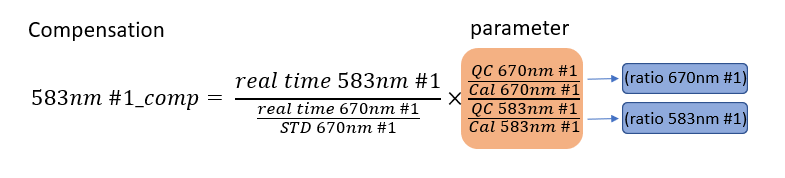
1. calculate parameter
2. build reference model
3. calculate ref_std

In [20]:
def ratio_calculator(df_qc, df_ref, channel):
    ratio = (df_qc[channel]/df_ref[channel]).mean()
    return ratio

In [21]:
def plot_overlay(data_list, cal_channel='583nm #1', QC_channel='583nm #1_comp', save_figure=True, offset=False):
    save_figure = save_figure
    offset = offset
    cal_channel = cal_channel
    QC_channel = QC_channel

    plot_data = []
    data_list = data_list

    if offset == True:
        trace_ppm = go.Scatter(y=df_30C[cal_channel]-df_30C.loc[1,cal_channel], name=cal_channel+' calibration')
        plot_data.append(trace_ppm)

        for i,j in enumerate(data_list):
            trace_ppm = go.Scatter(y=j[QC_channel]-j.loc[1,QC_channel], name=QC_channel+' QC{}'.format(i+1))
            plot_data.append(trace_ppm) 
    else:
        trace_ppm = go.Scatter(y=df_30C[cal_channel], name=cal_channel+' calibration')
        plot_data.append(trace_ppm)

        for i,j in enumerate(data_list):
            trace_ppm = go.Scatter(y=j[QC_channel], name=QC_channel+' QC{}'.format(i+1))
            plot_data.append(trace_ppm)


    title = '{} raw data overlay'.format(QC_channel)    
    layout = go.Layout(title=title)
    fig = go.Figure(data=plot_data, layout=layout)
    fig.show()

    if save_figure == True:
        # save figure
        savePath = os.path.join(os.getcwd(), folder_name)
        filename = title
        fig.write_image(savePath + '/' + filename + '.jpeg', width=1280, height=720)

In [22]:
def response_separation(data_list, QC_channel='583nm #1', save_figure=True):
    save_figure = save_figure
    QC_channel = QC_channel
    selected_range = { 'cycle 1':(15, 25, 35, 45)}

    diff_list = []
    for i,j in enumerate(test_data_list):
        diff = []
        a,b,c,d = selected_range.get('cycle 1')
        diff_a = j.loc[a, QC_channel]-j.loc[d, QC_channel]
        diff.append(abs(diff_a))
        diff_b = j.loc[b, QC_channel]-j.loc[d, QC_channel]
        diff.append(abs(diff_b))
        diff_c = j.loc[c, QC_channel]-j.loc[d, QC_channel]
        diff.append(abs(diff_c))
        diff_list.append(diff)
    index = ['QC{}'.format(i+1) for i in range(0, len(test_data_list))]
    by_diff = pd.DataFrame(diff_list, columns=['60ppm-4ppm','25ppm-4ppm','10ppm-4ppm'], index=index)

    plot_data = []
    trace = go.Bar(x=by_diff.index, y=by_diff.loc[:,'60ppm-4ppm'], name='60ppm-4ppm', text=by_diff.loc[:,'60ppm-4ppm'], textposition='auto')
    plot_data.append(trace)
    trace = go.Bar(x=by_diff.index, y=by_diff.loc[:,'25ppm-4ppm'], name='25ppm-4ppm', text=by_diff.loc[:,'25ppm-4ppm'], textposition='auto')
    plot_data.append(trace)
    trace = go.Bar(x=by_diff.index, y=by_diff.loc[:,'10ppm-4ppm'], name='10ppm-4ppm', text=by_diff.loc[:,'10ppm-4ppm'], textposition='auto')
    plot_data.append(trace)
    layout = go.Layout(title='{} response separation (baseline 4ppm)'.format(QC_channel))
    fig = go.Figure(data=plot_data, layout=layout)
    fig.update_layout()
    fig.show()

    if save_figure == True:
        # save figure
        savePath = os.path.join(os.getcwd(), folder_name)

        if not os.path.exists(savePath):
                os.makedirs(savePath)

        filename = '{} response separation (baseline 4ppm)'.format(QC_channel)
        fig.write_image(savePath + '/' + filename + '.jpeg', width=1280, height=720)

In [23]:
def drift_ratio_parameter(ref_channel, target_channel, df_ref, df_qc, save_parameter_difference = True, save_drifting_ratio_and_parameter = True):
    save_drifting_ratio_and_parameter = save_drifting_ratio_and_parameter
    save_parameter_difference = save_parameter_difference
    df_ref = df_ref
    df_qc = df_qc
    ref_channel = ref_channel
    target_channel = target_channel

    result = []
    for df_qc in test_data_list:    
        ratio_ref = ratio_calculator(df_qc, df_ref, ref_channel)
        ratio_target = ratio_calculator(df_qc, df_ref, target_channel)
        para = ratio_ref/ratio_target
        result.append([ratio_ref, ratio_target, para])

    index = ['QC{}'.format(i+1) for i in range(0, len(test_data_list))]
    by_ratio_parameter = pd.DataFrame(result, columns=['ratio_ref','ratio_target', 'parameter'], index=index)
    by_ratio_parameter['parameter difference'] = by_ratio_parameter.loc[:,'parameter'] - by_ratio_parameter.loc['QC1','parameter']

    plot_data = []
    trace = go.Scatter(x=by_ratio_parameter.index, y=by_ratio_parameter.loc[:, 'ratio_ref'], name='drift_{}'.format(ref_channel))
    plot_data.append(trace)
    trace = go.Scatter(x=by_ratio_parameter.index, y=by_ratio_parameter.loc[:, 'ratio_target'], name='drift_{}'.format(target_channel))
    plot_data.append(trace)
    trace = go.Scatter(x=by_ratio_parameter.index, y=by_ratio_parameter.loc[:, 'parameter'], name='parameter')
    plot_data.append(trace)
    layout = go.Layout(title='Drifting ratio and parameter')
    fig = go.Figure(data=plot_data, layout=layout)
    fig.update_traces(textposition='top center', textfont_size=14)
    fig.show()

    if save_drifting_ratio_and_parameter == True:
        savePath = os.path.join(os.getcwd(), folder_name)
        filename = 'Drifting ratio and parameter'
        fig.write_image(savePath + '/' + filename + '.jpeg', width=1280, height=720)
    #     by_ratio_parameter.to_csv(savePath + '/' + filename + '.csv')

    plot_data = []
    trace = go.Scatter(x=by_ratio_parameter.index, y=by_ratio_parameter.loc[:, 'parameter difference'], name='parameter difference')
    plot_data.append(trace)
    layout = go.Layout(title='parameter difference')
    fig = go.Figure(data=plot_data, layout=layout)
    fig.update_traces(textposition='top center', textfont_size=14)
    fig.show()

    if save_parameter_difference == True:
        savePath = os.path.join(os.getcwd(), folder_name)
        filename = 'parameter difference'
        fig.write_image(savePath + '/' + filename + '.jpeg', width=1280, height=720)
    #     by_ratio_parameter.to_csv(savePath + '/' + filename + '.csv')

In [24]:
path = data_loading()

D:/Data_store/AMS_7341/072121 NaN3_41411_verification/Algorithm Test


In [25]:
# 收尋path裡所有的資料夾、檔案的路徑
dirPath_list = []
dirNames_list = []
for dirPath, dirNames, _ in os.walk(path):
    dirPath_list.append(dirPath)
    dirNames_list.append(dirNames)

In [27]:
#合成各個sensor路徑
path_list = []
for sensor in dirNames_list[0]:
    if '#20' in sensor:
        sensor_path = os.path.join(dirPath_list[0],sensor).replace('\\', '/')
        path_list.append(sensor_path)
path_list

['D:/Data_store/AMS_7341/072121 NaN3_41411_verification/Algorithm Test/#20210420114245',
 'D:/Data_store/AMS_7341/072121 NaN3_41411_verification/Algorithm Test/#20210421111349',
 'D:/Data_store/AMS_7341/072121 NaN3_41411_verification/Algorithm Test/#20210421111948',
 'D:/Data_store/AMS_7341/072121 NaN3_41411_verification/Algorithm Test/#20210421112217',
 'D:/Data_store/AMS_7341/072121 NaN3_41411_verification/Algorithm Test/#20210421112443',
 'D:/Data_store/AMS_7341/072121 NaN3_41411_verification/Algorithm Test/#20210421112659',
 'D:/Data_store/AMS_7341/072121 NaN3_41411_verification/Algorithm Test/#20210421112925',
 'D:/Data_store/AMS_7341/072121 NaN3_41411_verification/Algorithm Test/#20210421113554']

In [28]:
# sensor_number = 16
# a = 1
# path_list = []
# while a <= sensor_number:
#     path = data_loading()
#     path_list.append(path)
#     a += 1

In [29]:
folder_name = 'test'
# folder_name = 'QC1~3 (2x583+1x620-2x550-3x510)(degree=1)(QC1 paremeter)'
# folder_name = 'QC1~4 (583 divide 583-510)(degree=1)'

# Sensor model setting 
sensor_humidity_feature = True
interpolation_model = 'log'
model_name = Ridge(alpha=10)                    #regression model
shift = 0                                      #raw data signal shifting
multiple = 1                                    #raw data ppm multiple
train_channel = 'z_score'                   #training channel
test_channel = 'z_score'                   #testing channel
degree = 2                                      #polynimial degree
output_modify = 1                               #output multiple


In [31]:
#sensor serial number
for path in path_list:      
    sensor_number = path.split('/')[-1]
    print('sensor_number:', sensor_number)
    
# load training data
    A = 0
    B = 300000

#     df_0C = data_pretreatment(pd.read_csv(path + '/select_data_calibration_0C.csv').reset_index(drop=True))
#     df_10C = data_pretreatment(pd.read_csv(path + '/select_data_calibration_10C.csv').reset_index(drop=True))
    df_20C = data_pretreatment(pd.read_csv(path + '/select_data_calibration_20C.csv').reset_index(drop=True))
    df_30C = data_pretreatment(pd.read_csv(path + '/select_data_calibration_30C.csv').reset_index(drop=True))
    df_40C = data_pretreatment(pd.read_csv(path + '/select_data_calibration_40C.csv').reset_index(drop=True))
    train_data_list = [
#                         df_0C, df_10C, 
                       df_20C, df_30C, df_40C]

# Load testing data
#     df_test_30C_1 = data_pretreatment(pd.read_csv(path + '/select_data_blind_test_30C_1.csv')[A:B].reset_index(drop=True))
#     df_test_30C_2 = data_pretreatment(pd.read_csv(path + '/select_data_blind_test_30C_2.csv')[A:B].reset_index(drop=True))
    df_test_30C_3 = data_pretreatment(pd.read_csv(path + '/select_data_blind_test_30C_3.csv')[A:B].reset_index(drop=True))
    df_test_30C_4 = data_pretreatment(pd.read_csv(path + '/select_data_blind_test_30C_4.csv')[A:B].reset_index(drop=True))
    df_test_30C_5 = data_pretreatment(pd.read_csv(path + '/select_data_blind_test_30C_5.csv')[A:B].reset_index(drop=True))
    # df_test_30C_6 = data_pretreatment(pd.read_csv(path + '/select_data_blind_test_30C_6.csv')[A:B].reset_index(drop=True))
    # df_test_30C_7 = data_pretreatment(pd.read_csv(path + '/select_data_blind_test_30C_7.csv')[A:B].reset_index(drop=True))
    # df_test_30C_8 = data_pretreatment(pd.read_csv(path + '/select_data_blind_test_30C_8.csv')[A:B].reset_index(drop=True))
    # df_test_30C_9 = data_pretreatment(pd.read_csv(path + '/select_data_blind_test_30C_9.csv')[A:B].reset_index(drop=True))
    # df_test_30C_10 = data_pretreatment(pd.read_csv(path + '/select_data_blind_test_30C_10.csv')[A:B].reset_index(drop=True))
    # df_test_30C_11 = data_pretreatment(pd.read_csv(path + '/select_data_blind_test_30C_11.csv')[A:B].reset_index(drop=True))

    test_data_list = [
#                       df_test_30C_1, 
#                       df_test_30C_2, 
                      df_test_30C_3, 
                      df_test_30C_4,
                      df_test_30C_5,
    #                   df_test_30C_6,
    #                   df_test_30C_7, 
    #                   df_test_30C_8,
    #                   df_test_30C_9,
    #                   df_test_30C_10,
    #                   df_test_30C_11,
                     ]

#     print('df_0C:', df_0C.shape)
#     print('df_10', df_10C.shape)
#     print('df_20C:', df_20C.shape)
#     print('df_30C:', df_30C.shape)
#     print('df_40C:', df_40C.shape)
#     print('-------------------------------------')
#     print('df_test_30C_1:', df_test_30C_1.shape)
#     print('df_test_30C_2:', df_test_30C_2.shape)
    # print('df_test_30C_3:', df_test_30C_3.shape)
    # print('df_test_30C_4:', df_test_30C_4.shape)
    # print('df_test_30C_5:', df_test_30C_5.shape)
    # print('df_test_30C_6:', df_test_30C_6.shape)

# calculate parameter

    df_ref = df_30C
    df_qc = df_test_30C_4
    channel_list = ['670nm #1', 'magic']

    ratio_ref = ratio_calculator(df_qc, df_ref, channel_list[0])
    ratio_target = ratio_calculator(df_qc, df_ref, channel_list[1])
    parameter = ratio_ref/ratio_target
    print('ratio_ref:{:.4f}'.format(ratio_ref))
    print('ratio_target:{:.4f}'.format(ratio_target))
    print('compensation_parameter:{:.4f}'.format(parameter))

# reference model setting 

# white card paremeter setting 
    # folder_name = 'QC1~2 (583+620-550-510)(degree=1)(QC1 paremeter)'
    # folder_name = 'QC1~2 (2x583+1x620-2x550-3x510)(degree=1)(QC1 paremeter)'
    # folder_name = 'QC1~2 (2x583+1x620-2x550-3x510)(degree=1)'
    # folder_name = 'QC3_583nm_comp_log_model(K1+QC1)(degree 2)'

    model_name = Ridge(alpha=10)                    #regression model
    channel = '670nm #1'                       #regression channel
    degree_white_card = 2                                   #polynimial degree
    humidity_step = ['RH40%', 'RH50%', 'RH60%', 'RH70%', 'RH80']
    white_card_humidity_feature = False

    df_all = pd.concat(train_data_list).reset_index(drop=True)
    df_test = pd.concat([df_30C]).reset_index(drop=True)

    y_train = df_all[channel]
    x_train = df_all[['Temperature', 'Humidity']]
    y_test = df_test[channel]
    x_test = df_test[['Temperature', 'Humidity']]

    os.chdir(path) 
    white_card = model.model(folder_name=folder_name,
                             sensor_number=sensor_number,
                             channel=channel,
                             x_train=x_train, 
                             y_train=y_train, 
                             x_test=x_test, 
                             y_test=y_test, 
                             model_name=model_name, 
                             degree=degree_white_card,
                             step=humidity_step,                         
                             ppm=-23,
                             humidity_feature=white_card_humidity_feature)

    white_intercept, white_coef = white_card.regression()
    white_card.save_white_card_side_coef(parameter=parameter)
#     white_card.plot()
    # white_intercept, white_coef = white_card.coef()

# target channel compensation by parameter
    for test_data in test_data_list: 
        white_card_std.create_white_card_std_column(test_data, white_intercept, white_coef, degree_white_card)
        test_data['670nm_real time ratio']  = test_data['670nm #1']/test_data['white card std']

        channal_list = ['620nm #1', 
                        '670nm #1', 
                        '470nm #1', 
                        '510nm #1', 
                        '550nm #1', 
                        '583nm #1', 
                        'magic', 
#                         'std'
                       ]
        for comp_channel in channal_list:
            test_data['{}_comp'.format(comp_channel)] = (test_data[comp_channel]/test_data['670nm_real time ratio'])*parameter

# Sensor model setting 

#     sensor_humidity_feature = False
#     interpolation_model = 'log'
#     model_name = Ridge(alpha=10)                    #regression model
#     shift = 0                                      #raw data signal shifting
#     multiple = 1                                    #raw data ppm multiple
#     train_channel = 'magic'                   #training channel
#     test_channel = 'magic'                    #testing channel
#     degree = 1                                      #polynimial degree
#     output_modify = 1                               #output multiple

# load training data 
#     dk_0C = df_0C.copy().reset_index(drop=True)
#     dk_10C = df_10C.copy().reset_index(drop=True)
    dk_20C = df_20C.copy().reset_index(drop=True)
    dk_30C = df_30C.copy().reset_index(drop=True)
    dk_40C = df_40C.copy().reset_index(drop=True)

# copy testing data
#     dk_test_30C_1 = df_test_30C_1.copy().reset_index(drop=True)
#     dk_test_30C_2 = df_test_30C_2.copy().reset_index(drop=True)
    dk_test_30C_3 = df_test_30C_3.copy().reset_index(drop=True)
    dk_test_30C_4 = df_test_30C_4.copy().reset_index(drop=True)
    dk_test_30C_5 = df_test_30C_5.copy().reset_index(drop=True)
    # dk_test_30C_6 = df_test_30C_6.copy().reset_index(drop=True)
    # dk_test_30C_7 = df_test_30C_7.copy().reset_index(drop=True)
    # dk_test_30C_8 = df_test_30C_8.copy().reset_index(drop=True)
    # dk_test_30C_9 = df_test_30C_9.copy().reset_index(drop=True)
    # dk_test_30C_10 = df_test_30C_10.copy().reset_index(drop=True)
    # dk_test_30C_11 = df_test_30C_11.copy().reset_index(drop=True)

# setting temperature range 
    # dict = {temp. 1 : ([training data1, data2], [blind test data1, data2], white_card_std data)}

    temp_data_dict = { 

        # 0~40C
        'temp. 1': ([dk_20C, dk_30C, dk_40C], [
#                                                               dk_test_30C_1, 
#                                                               dk_test_30C_2, 
                                                              dk_test_30C_3, 
                                                              dk_test_30C_4, 
                                                              dk_test_30C_5,
    #                                                           dk_test_30C_6,
    #                                                           dk_test_30C_7,
    #                                                           dk_test_30C_8,
    #                                                           dk_test_30C_9,
    #                                                           dk_test_30C_10,
    #                                                           dk_test_30C_11,
                                                             ]),



                      } 

    # implement temp. range loop
    for temp_data, temp_blind_test in temp_data_dict.values():


        # plot each model 4D data
    #             module_4D.plot_4D_multi_model(temp_data, temp_blind_test, channel_list, sensor_number)

        # concate training data        
        df_all = pd.concat(temp_data).reset_index(drop=True)
        df_test = pd.concat(temp_blind_test).reset_index(drop=True)   

        # 取0ppm資料
        dk_all_0ppm = df_all[df_all['ppm']<1].copy()

        # 取4ppm資料
        dk_all_4ppm = df_all[(df_all['ppm']>3)&(df_all['ppm']<5)].copy()

        # 取10ppm資料
        dk_all_10ppm = df_all[(df_all['ppm']>9)&(df_all['ppm']<11)].copy()

        # 取25ppm資料
        dk_all_25ppm = df_all[(df_all['ppm']>24)&(df_all['ppm']<26)].copy()

        # 取60ppm資料
        dk_all_60ppm = df_all[(df_all['ppm']>59)&(df_all['ppm']<61)].copy()


        dk_data_dict = {
    #                     0:(dk_all_0ppm),
                        4:(dk_all_4ppm),
                        10:(dk_all_10ppm),
                        25:(dk_all_25ppm),
    #                     60:(dk_all_60ppm)
                   }


        #training model for 0ppm, 10ppm, 60ppm surface
        surf_coef_list = []                           # store ppm surface coefficient
        for ppm, ppm_data in dk_data_dict.items():

            dk_data = ppm_data
            y_train = dk_data[train_channel] + shift 
            x_train = dk_data[['Temperature', 'Humidity']]
            y_test = df_test[test_channel]
            x_test = df_test[['Temperature', 'Humidity']]

    #             channels = train_channel

            #開始計算濃度平面 model by Ridge regression
    #         step = humidity_step
            os.chdir(path)              
            loss_list = []
            loss_each_step_list = []
            sensor = model.model(folder_name=folder_name,
                                 sensor_number=sensor_number,
                                 channel=train_channel,
                                 x_train=x_train, 
                                 y_train=y_train, 
                                 x_test=x_test, 
                                 y_test=y_test, 
                                 model_name=model_name, 
                                 degree=degree,
                                 step=humidity_step,
                                 output_modify=output_modify,
                                 shift=shift,            
                                 multiple=multiple,
                                 ppm=ppm,
                                 humidity_feature=sensor_humidity_feature                             
                                 )
            sensor.regression()
            intercept_and_coefficient = sensor.save_sensor_side_coef()
    #         print(intercept_and_coefficient)
    #         sensor.loss()
    #         loss_each_step = sensor.loss_each_step()    
            sensor.plot()
    #         sensor.save_plot()
    #         sensor.coef()

            surf_coef_list.append(intercept_and_coefficient) 

        test_data = df_test[[test_channel, 'Temperature', 'Humidity', 'ppm']]
        ppm_list = []
        for index, row in test_data.iterrows():
            signal, temperature, humidity, _ = row
    #         signal_0ppm = interpolation.calculate_ppm_surface_signal(surf_coef_list[0], x0=temperature, x1=humidity, degree=degree)
            signal_4ppm = interpolation.calculate_ppm_surface_signal(surf_coef_list[0], x0=temperature, x1=humidity, degree=degree)
            signal_10ppm = interpolation.calculate_ppm_surface_signal(surf_coef_list[1], x0=temperature, x1=humidity, degree=degree)
            signal_25ppm = interpolation.calculate_ppm_surface_signal(surf_coef_list[2], x0=temperature, x1=humidity, degree=degree)
    #         signal_60ppm = interpolation.calculate_ppm_surface_signal(surf_coef_list[4], x0=temperature, x1=humidity, degree=degree)


    #         print(signal_0ppm, signal_10ppm, signal_60ppm)

            signal_ppm_dict = {
    #                              0:signal_0ppm,
                                 4:signal_4ppm,
                                10:signal_10ppm,
                                25:signal_25ppm,
    #                             60:signal_60ppm,
                               }

            if interpolation_model == 'linear':
                ppm = interpolation.linear_interpolation(signal_ppm_dict, signal, 4, 10, 25)

            elif interpolation_model == 'log':
                ppm = interpolation.log_interpolation(signal_ppm_dict, signal, 4, 10, 25)
                
            elif interpolation_model == 'hybrid':
                ppm = interpolation.hybrid_interpolation(signal_ppm_dict, signal, 4, 10, 25)

            ppm_list.append(ppm)

        # RMSE
        rmse_test = np.sqrt(mean_squared_error(ppm_list, test_data['ppm'])).round(2)

        # Interpolation prediction result    
        predict_test_data = test_data.copy()
        predict_test_data['pred_ppm'] = ppm_list
        temp = int(predict_test_data['Temperature'].mean())
        hum_min = int(predict_test_data['Humidity'].min())
        hum_max = int(predict_test_data['Humidity'].max())
        title = '({}) ({}%~{}%) ({}) (RMSE={})'.format(sensor_number, hum_min, hum_max, test_channel, rmse_test)

        # plot prediction result
    #     predict_test_data.iplot(kind='scatter', y=['ppm', 'pred_ppm', 'Humidity', 'Temperature'], title=title)
        plot_data = []
        trace_ppm = go.Scatter(y=predict_test_data['ppm'], name='ppm')
        plot_data.append(trace_ppm)

        trace_pred_ppm = go.Scatter(y=predict_test_data['pred_ppm'], name='pred_ppm')
        plot_data.append(trace_pred_ppm)

        trace_RH = go.Scatter(y=predict_test_data['Humidity'], name='Humidity')
        plot_data.append(trace_RH)

        trace_temp = go.Scatter(y=predict_test_data['Temperature'], name='Temperature')
        plot_data.append(trace_temp)

        layout = go.Layout(xaxis=dict(range=[0, predict_test_data.shape[0]]), title=title)

        fig = go.Figure(data=plot_data, layout=layout)
        fig.show()

        # save figure
        savePath = os.path.join(os.getcwd(), folder_name)
        filename = '({}%~{}%)({})(shift {})(RMSE={})'.format(hum_min, hum_max, test_channel, shift ,rmse_test)
#         fig.write_image(savePath + '/' + filename + '.jpeg', width=1280, height=720)
        fig.write_image('D:\\Data_store\\AMS_7341\\071921 Intemo MP test_(T+U lot 07132021, 0~40C, 16 units per round)\\Group2' + '/' + sensor_number + ' ' + filename + '.jpeg', width=1280, height=720)



# Overview 4D data
# 4D plot
#     training_data = {
#                  '0C':df_0C,
#                  '10C':df_10C,
#                  '20C':df_20C,
#                  '30C':df_30C,
#                  '40C':df_40C,
#                      }

#     testing_data = {
#                  '30C_test_1':df_test_30C_1,
#                  '30C_test_2':df_test_30C_2,
    #              '30C_test_3':df_test_30C_3,

#                    }

#     channel_list=['583nm #1']
    # module_4D.plot_4D(training_data, testing_data, channel_list, sensor_number)

# Analysis data 

#     plot_overlay(data_list=test_data_list, cal_channel='583nm #1', QC_channel='583nm #1', save_figure=True, offset=True)
#     plot_overlay(data_list=test_data_list, cal_channel='670nm #1', QC_channel='670nm #1', save_figure=False, offset=False)
#     plot_overlay(data_list=test_data_list, cal_channel='magic', QC_channel='magic', save_figure=True, offset=False)
#     plot_overlay(data_list=test_data_list, cal_channel='magic', QC_channel='magic_comp', save_figure=True, offset=False)

    # ams = ['410nm #1', '440nm #1', '470nm #1', '510nm #1', '550nm #1',
    #        '583nm #1', '620nm #1', '670nm #1', '900nm #1']
    # for c in ams:
    #     plot_overlay(data_list=test_data_list, cal_channel=c, QC_channel=c, save_figure=True, offset=False)
    
#     response_separation(data_list=test_data_list, QC_channel='583nm #1', save_figure=True)
#     drift_ratio_parameter(ref_channel='670nm #1', 
#                           target_channel='magic', 
#                           df_ref=df_30C, 
#                           df_qc=test_data_list, 
#                           save_parameter_difference=False,
#                           save_drifting_ratio_and_parameter=False,)

sensor_number: #20210420114245
ratio_ref:1.0311
ratio_target:1.0152
compensation_parameter:1.0156


sensor_number: #20210421111349
ratio_ref:1.0090
ratio_target:0.9953
compensation_parameter:1.0137


sensor_number: #20210421111948
ratio_ref:1.0372
ratio_target:1.0163
compensation_parameter:1.0206


sensor_number: #20210421112217
ratio_ref:1.0096
ratio_target:0.9982
compensation_parameter:1.0114


sensor_number: #20210421112443
ratio_ref:1.0195
ratio_target:1.0087
compensation_parameter:1.0107


sensor_number: #20210421112659
ratio_ref:1.0304
ratio_target:1.0232
compensation_parameter:1.0071


sensor_number: #20210421112925
ratio_ref:1.0186
ratio_target:1.0023
compensation_parameter:1.0162


sensor_number: #20210421113554
ratio_ref:1.0310
ratio_target:1.0195
compensation_parameter:1.0113
